In [1]:
from __future__ import print_function
import os.path
import pandas as pd
import gzip
import sys
import numpy as np

sys.path.insert(0, '..')

from src.CCLE_postp_function import *
from JKBio import Datanalytics as da 
from JKBio import TerraFunction as terra
from JKBio import Helper as h
from gsheets import Sheets
from taigapy import TaigaClient
import dalmatian as dm

from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier

from bokeh.plotting import *
from bokeh.models import HoverTool
from collections import OrderedDict
from IPython.display import Image,display



%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
tc = TaigaClient()
output_notebook()
sheets = Sheets.from_files('~/.client_secret.json', '~/.storage.json')
replace = {'T': 'Tumor', 'N': 'Normal', 'm': 'Unknown', 'L': 'Unknown'}

you need to have installed JKBio in the same folder as ccle_processing


Loading BokehJS ...

# boot up

we are instanciating all the parameters needed for this pipeline to run

In [4]:
samplesetname = "20Q3"
prevname="20Q2"
prevversion = 22
prevprevname ='20Q1'
prevprevversion= 20
virtual_internal='internal-20q3-00d0'

refworkspace="broad-firecloud-ccle/DepMap_Mutation_Calling_CGA_pipeline"



refsheet_url = "https://docs.google.com/spreadsheets/d/1XkZypRuOEXzNLxVk9EOHeWRE98Z8_DBvL4PovyM01FE"
sheeturl = "https://docs.google.com/spreadsheets/d/115TUgA1t_mD32SnWAGpW9OKmJ2W5WYAOs3SuSdedpX4"

release = samplesetname

In [5]:
%%R
release <- '20Q3'
prevname <- '20Q2'
genome_version <- 'hg19'
taiga_version <- 10
prevversion <-13

In [6]:
refwm = dm.WorkspaceManager(refworkspace)

In [233]:
res = refwm.get_sample_sets().loc["all"]
res

filtered_CGA_MAF_aggregated      gs://fc-secure-012d088c-f039-4d36-bde5-ee9b1b7...
samples                          [CDS-00rz9N, CDS-01bI6z, CDS-02waxZ, CDS-04TUV...
merged_mutations                 gs://fc-secure-012d088c-f039-4d36-bde5-ee9b1b7...
merged_vcf                       gs://fc-secure-012d088c-f039-4d36-bde5-ee9b1b7...
unfiltered_CGA_MAF_aggregated    gs://fc-secure-012d088c-f039-4d36-bde5-ee9b1b7...
Name: all, dtype: object

In [8]:
filtered = res['filtered_CGA_MAF_aggregated']
! gsutil cp $filtered "temp/mutation_filtered_terra_merged.txt"

Copying gs://fc-secure-012d088c-f039-4d36-bde5-ee9b1b76b912/b49f7c3a-3f14-49e4-a464-006490d4a37b/aggregateMAFs_selectFields_workflow/66076582-bcd7-44d9-bfde-ee81bcb677e9/call-aggregateMAFs_selectFields/all.mergedMAF.txt...
/ [1 files][253.5 MiB/253.5 MiB]                                                
Operation completed over 1 objects/253.5 MiB.                                    


In [9]:
file = pd.read_csv('temp/mutation_filtered_terra_merged.txt',sep='\t') 
print(file.columns[:10])
renaming = removeOlderVersions(names = set(file['Tumor_Sample_Barcode']), refsamples = refwm.get_samples(), arxspan_id = "arxspan_id", version="version")
print(file[file['Chromosome']=='0'])
file[file['Tumor_Sample_Barcode'].isin(renaming.keys())].replace({'Tumor_Sample_Barcode':renaming}).reset_index(drop=True).to_csv('temp/mutation_filtered_terra_merged.txt',sep='\t',index=None)

/home/jeremie/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['Hugo_Symbol', 'Entrez_Gene_Id', 'Center', 'NCBI_Build', 'Chromosome',
       'Start_position', 'End_position', 'Strand', 'Variant_Classification',
       'Variant_Type'],
      dtype='object')
removed 247 duplicate samples
Empty DataFrame
Columns: [Hugo_Symbol, Entrez_Gene_Id, Center, NCBI_Build, Chromosome, Start_position, End_position, Strand, Variant_Classification, Variant_Type, Reference_Allele, Tumor_Seq_Allele1, Tumor_Seq_Allele2, dbSNP_RS, dbSNP_Val_Status, Genome_Change, Annotation_Transcript, Tumor_Sample_Barcode, cDNA_Change, Codon_Change, Protein_Change, t_alt_count, t_ref_count, tumor_f, isDeleterious, isTCGAhotspot, TCGAhsCnt, isCOSMIChotspot, COSMIChsCnt, i_ExAC_AF, PASS]
Index: []

[0 rows x 31 columns]


In [19]:
ls ../JKBio/

CCLF_processing.py         helper/                requirements.txt
cell_line_mapping-master/  Helper.py              RScript.R
data/                      __init__.py            setup.py
Datanalytics.py            LICENSE                taigr/
epigenetics/               my_custom_commands.sh  TerraFunction.py
GCPFunction.py             __pycache__/
generate_sample_info.sh    README.md


# Analysis

In [57]:
%%R
#source('src/load_libraries_and_annotations.R')
load('src/Annotations.rdata') 
# There are some cell lines the celllinemapr does not know how to map so we need to load this data object for now (from old datasets)
source('src/CCLE_postp_function.R')
library('cdsomics')
library(tidyverse)
library(data.table)
library(magrittr)
library(taigr)
library(cdsomics)
library(celllinemapr) # To pull out DepMap_IDs from CCLE_names where needed

In [24]:
%%R
newly_merged_maf <- readMutations('temp/mutation_filtered_terra_merged.txt')
new_release <- createSNPs(newly_merged_maf)
names(new_release)

 [1] "Hugo_Symbol"            "Entrez_Gene_Id"         "NCBI_Build"            
 [4] "Chromosome"             "Start_position"         "End_position"          
 [7] "Strand"                 "Variant_Classification" "Variant_Type"          
[10] "Reference_Allele"       "Tumor_Seq_Allele2"      "dbSNP_RS"              
[13] "dbSNP_Val_Status"       "Genome_Change"          "Annotation_Transcript" 
[16] "Tumor_Sample_Barcode"   "cDNA_Change"            "Codon_Change"          
[19] "Protein_Change"         "isDeleterious"          "isTCGAhotspot"         
[22] "TCGAhsCnt"              "isCOSMIChotspot"        "COSMIChsCnt"           
[25] "t_alt_count"            "t_ref_count"            "ExAC_AF"               
[28] "pass"                  


In [29]:
%%R
new_release <- renameAsInMainMutation(new_release)

In [58]:
%%R
filtered <- filterAllelicFraction(new_release)

[1] 1002964      29


In [63]:
%%R
write.table(
  filtered$merged, 
  paste0('temp/newmutations.', release, '.all.csv'), sep = ',', quote = F, row.names = F)

In [59]:
%%R
filtered <- filterMinCoverage(filtered$merged, filtered$removed_from_maf)

R[write to console]: Error in `[.data.frame`(merged_latest_release, , c("CGA_WES_AC", "WGS_AC",  : 
  undefined columns selected
Calls: <Anonymous> ... withVisible -> filterMinCoverage -> apply -> [ -> [.data.frame

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In FUN(newX[, i], ...) :
R[write to console]:  NAs introduced by coercion

R[write to console]: 2: 
R[write to console]: In FUN(newX[, i], ...) :
R[write to console]:  NAs introduced by coercion




Error in `[.data.frame`(merged_latest_release, , c("CGA_WES_AC", "WGS_AC",  : 
  undefined columns selected
Calls: <Anonymous> ... withVisible -> filterMinCoverage -> apply -> [ -> [.data.frame


In [ ]:
%%R
head(merged)

In [ ]:
%%R
clean_annotations <- mergeAnnotations(merged,previous.release.maf)

In [ ]:
%%R

# Allie's version
new_release <- addAnnotation(new_release)

In [ ]:
%%R
# some matric files that does get used internaly and might be useful
damaging_mutation <- mutation_maf_to_binary_matrix(new_release, damaging =  TRUE)
other_mutation <- mutation_maf_to_binary_matrix(new_release, other = TRUE)
hotspot_mutation <- mutation_maf_to_binary_matrix(new_release, hotspot = TRUE)

In [ ]:
%%R
# Save the ready to upload file to upload to taiga
write.table(
  new_release, 
  paste0('temp/mutations.', release, '.all.csv'), sep = ',', quote = F, row.names = F)
# Save the ready to upload file to upload to taiga
write.table(
  damaging_mutation, 
  paste0('temp/damaging_mutation.', release, '.all.csv'), sep = ',', quote = F)
# Save the ready to upload file to upload to taiga
write.table(
  other_mutation, 
  paste0('temp/other_mutation.', release, '.all.csv'), sep = ',', quote = F)
# Save the ready to upload file to upload to taiga
write.table(
  hotspot_mutation, 
  paste0('temp/hotspot_mutation.', release, '.all.csv'), sep = ',', quote = F)

In [153]:
newmutations = pd.read_csv('temp/mutations.'+release+'.all.csv')

/home/jeremie/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [154]:
mutations_20Q2_all = tc.get(name='depmap-mutations-maf-35fe', version=14, file='mutations.20Q2.all')

# Comparing

## initial, simple

In [155]:
#removing all of the WGS and snp arrays
mutations_20Q2_all = mutations_20Q2_all[~mutations_20Q2_all.DepMap_ID.isin(set(mutations_20Q2_all.DepMap_ID) - set(newmutations.Tumor_Sample_Barcode))]

### strange new cell lines

In [11]:
#Too recent? removed by what means? why?
set(newmutations.Tumor_Sample_Barcode) - set(mutations_20Q2_all.DepMap_ID)

{'ACH-001061',
 'ACH-001098',
 'ACH-001194',
 'ACH-001227',
 'ACH-001678',
 'ACH-001847',
 'ACH-002048',
 'ACH-002138',
 'ACH-002204'}

In [156]:
newmutations = newmutations[~newmutations.Tumor_Sample_Barcode.isin(set(newmutations.Tumor_Sample_Barcode) - set(mutations_20Q2_all.DepMap_ID))]

In [157]:
newmutations = newmutations.sort_values(by=['Tumor_Sample_Barcode','Chromosome','Start_position','End_position'])
mutations_20Q2_all = mutations_20Q2_all.sort_values(by=['DepMap_ID','Chromosome','Start_position','End_position'])

In [158]:
newmutations[['Tumor_Sample_Barcode','Chromosome','Start_position','End_position']] = newmutations[['Tumor_Sample_Barcode','Chromosome','Start_position','End_position']].astype(str)
newmutationsset = newmutations['Tumor_Sample_Barcode']+'_'+newmutations['Chromosome']+':'+newmutations['Start_position']+'-'+newmutations['End_position']
newmutations['grouped'] = newmutationsset

In [159]:
len(newmutationsset)

986724

In [160]:
dups = h.dups(newmutationsset)

In [161]:
len(dups)

0

In [162]:
newmutationsset = set(newmutationsset)

In [163]:
mutations_20Q2_all[['DepMap_ID','Chromosome','Start_position','End_position']] = mutations_20Q2_all[['DepMap_ID','Chromosome','Start_position','End_position']].astype(str)
mutations_20Q2_allset = mutations_20Q2_all['DepMap_ID']+'_'+mutations_20Q2_all['Chromosome']+':'+mutations_20Q2_all['Start_position']+'-'+mutations_20Q2_all['End_position']
mutations_20Q2_all['grouped'] = mutations_20Q2_allset

In [164]:
len(mutations_20Q2_allset)

1265853

In [165]:
dups = h.dups(mutations_20Q2_allset)

### issues with duplicates

In [166]:
## How come?? the merging did not work well
len(dups)

7367

In [167]:
mutations_20Q2_all[mutations_20Q2_all['grouped']==dups[0]]

,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,CGA_WES_AC,SangerWES_AC,SangerRecalibWES_AC,RNAseq_AC,HC_AC,RD_AC,WGS_AC,Variant_annotation,DepMap_ID,grouped
215969,CIT,11113,37,12,120204966,120204966,+,Silent,SNP,C,...,29:0,None,None,None,None,None,None,silent,ACH-001670,ACH-001670_12:120204966-120204966
215970,CIT,11113,37,12,120204966,120204966,+,Silent,SNP,C,...,None,68:0,62:0,None,None,None,None,silent,ACH-001670,ACH-001670_12:120204966-120204966


In [173]:
mutations_20Q2_all[mutations_20Q2_all['grouped']==dups[0]][mutations_20Q2_all.columns[:20]]

,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,dbSNP_RS,dbSNP_Val_Status,Genome_Change,Annotation_Transcript,Tumor_Sample_Barcode,cDNA_Change,Codon_Change,Protein_Change,isDeleterious
215969,CIT,11113,37,12,120204966,120204966,+,Silent,SNP,C,T,None,None,g.chr12:120204966C>T,ENST00000261833.7,ACH-001670,c.2103G>A,c.(2101-2103)cgG>cgA,p.R701R,False
215970,CIT,11113,37,12,120204966,120204966,+,Silent,SNP,C,T,None,None,g.chr12:120204966C>T,ENST00000261833.7,ACH-001670,c.2103G>A,c.(2101-2103)cgG>cgA,p.R701R,False


In [273]:
submutations_20Q2_all = mutations_20Q2_all[~mutations_20Q2_all.CGA_WES_AC.isna()]

In [169]:
len(submutations_20Q2_all) 

462966

In [274]:
submutations_20Q2_allset = submutations_20Q2_all.grouped

In [275]:
mutations_20Q2_allset = mutations_20Q2_all.grouped

### similarity

In [174]:
len(set(submutations_20Q2_allset) & set(newmutationsset))/ len(submutations_20Q2_allset)

0.9918136537024317

In [196]:
[i for i in submutations_20Q2_allset if type(i)!= str]

[]

In [198]:
len(set(submutations_20Q2_allset) - set(newmutationsset))

3191

In [175]:
len(set(submutations_20Q2_allset) & set(newmutationsset))/ len(newmutationsset)

0.46535404023820237

In [276]:
subnewmutationsset = set(newmutations[newmutations.Tumor_Sample_Barcode.isin(submutations_20Q2_all.DepMap_ID)].grouped)
len(set(submutations_20Q2_allset) & set(subnewmutationsset))/ len(subnewmutationsset)

0.9933520678249169

In [200]:
len(set(subnewmutationsset)- set(submutations_20Q2_allset))

3073

### similarity with everything from all datasets

In [207]:
len(set(newmutationsset) - set(mutations_20Q2_allset))

35547

In [208]:
len(set(mutations_20Q2_allset) & set(newmutationsset))/ len(mutations_20Q2_allset)

0.751411893798095

In [204]:
len(set(mutations_20Q2_all[mutations_20Q2_all.DepMap_ID.isin(newmutations.Tumor_Sample_Barcode)].grouped) - set(newmutations[newmutations.Tumor_Sample_Barcode.isin(mutations_20Q2_all.DepMap_ID)].grouped))

307309

In [178]:
submutations_20Q2_all[submutations_20Q2_all.grouped.isin(set(submutations_20Q2_allset) - set(newmutationsset))]

,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,CGA_WES_AC,SangerWES_AC,SangerRecalibWES_AC,RNAseq_AC,HC_AC,RD_AC,WGS_AC,Variant_annotation,DepMap_ID,grouped
1165855,TRIM51,84767,37,11,55653610,55653610,+,Frame_Shift_Del,DEL,A,...,54:59,None,None,None,None,None,None,damaging,ACH-000007,ACH-000007_11:55653610-55653610
273033,DACH1,1602,37,13,72440538,72440539,+,In_Frame_Ins,INS,-,...,26:98,None,None,None,None,None,None,other non-conserving,ACH-000007,ACH-000007_13:72440538-72440539
82171,ARIH1,25820,37,15,72767214,72767215,+,In_Frame_Ins,INS,-,...,46:32,None,None,None,None,None,None,other non-conserving,ACH-000007,ACH-000007_15:72767214-72767215
212898,CHRNE,1145,37,17,4802798,4802799,+,Frame_Shift_Ins,INS,-,...,107:107,None,None,None,None,None,13:17,damaging,ACH-000007,ACH-000007_17:4802798-4802799
157133,CACNB1,782,37,17,37341119,37341120,+,Splice_Site,INS,-,...,51:48,None,None,None,None,None,None,damaging,ACH-000007,ACH-000007_17:37341119-37341120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156165,TP53,7157,37,17,7579533,7579533,+,Frame_Shift_Del,DEL,G,...,83:154,None,None,None,None,None,None,damaging,ACH-002461,ACH-002461_17:7579533-7579533
344631,ENOSF1,55556,37,18,691068,691069,+,Splice_Site,DEL,CT,...,69:55,None,None,None,None,None,None,damaging,ACH-002461,ACH-002461_18:691068-691069
1008336,SIGLEC9,27180,37,19,51628387,51628387,+,Frame_Shift_Del,DEL,C,...,111:270,None,None,None,None,None,None,damaging,ACH-002461,ACH-002461_19:51628387-51628387
30658,ADNP,23394,37,20,49509245,49509245,+,Frame_Shift_Del,DEL,C,...,86:434,None,None,None,None,None,None,damaging,ACH-002461,ACH-002461_20:49509245-49509245


In [277]:
notfound = submutations_20Q2_all[submutations_20Q2_all.grouped.isin(set(submutations_20Q2_allset) - set(newmutationsset))]

In [209]:
len(notfound)

3191

In [279]:
# how many genes
len(set(notfound.Hugo_Symbol))

2408

In [289]:
newmutations

,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,TCGAhsCnt,isCOSMIChotspot,COSMIChsCnt,ExAC_AF,CGA_WES_AC,PERC_CGA_WES_AC,MAX_AF,PERC_PERC_CGA_WES_AC,INCLUDE,grouped
189786,VPS13D,55187,__UNKNOWN__,1,12359347,12359347,__UNKNOWN__,Nonsense_Mutation,SNP,C,...,NaN,False,0.0,NaN,34:213,0.137652,0.5,0.5,True,ACH-000001_1:12359347-12359347
959813,AADACL4,343066,__UNKNOWN__,1,12726308,12726322,__UNKNOWN__,In_Frame_Del,DEL,CTGGCGTGACGCCAT,...,NaN,False,3.0,NaN,57:141,0.287879,0.5,0.5,True,ACH-000001_1:12726308-12726322
189787,IFNLR1,163702,__UNKNOWN__,1,24484172,24484172,__UNKNOWN__,Silent,SNP,G,...,NaN,False,0.0,NaN,118:0,1.000000,1.0,0.5,True,ACH-000001_1:24484172-24484172
189788,ZSCAN20,7579,__UNKNOWN__,1,33954141,33954141,__UNKNOWN__,Missense_Mutation,SNP,T,...,NaN,False,0.0,NaN,28:62,0.311111,0.5,0.5,True,ACH-000001_1:33954141-33954141
189789,GBP4,115361,__UNKNOWN__,1,89657103,89657103,__UNKNOWN__,Silent,SNP,G,...,NaN,False,0.0,0.000016,96:0,1.000000,1.0,0.5,True,ACH-000001_1:89657103-89657103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901963,CYLC1,1538,__UNKNOWN__,X,83126495,83126495,__UNKNOWN__,Missense_Mutation,SNP,C,...,NaN,False,0.0,NaN,34:38,0.472222,0.5,0.5,True,ACH-003000_X:83126495-83126495
901964,COL4A6,1288,__UNKNOWN__,X,107400439,107400439,__UNKNOWN__,Missense_Mutation,SNP,A,...,NaN,False,0.0,NaN,59:0,1.000000,1.0,0.5,True,ACH-003000_X:107400439-107400439
901965,COL4A5,1287,__UNKNOWN__,X,107821607,107821607,__UNKNOWN__,Silent,SNP,A,...,NaN,False,0.0,NaN,95:0,1.000000,1.0,0.5,True,ACH-003000_X:107821607-107821607
901966,GPR112,139378,__UNKNOWN__,X,135426613,135426613,__UNKNOWN__,Missense_Mutation,SNP,A,...,NaN,False,0.0,NaN,48:0,1.000000,1.0,0.5,True,ACH-003000_X:135426613-135426613


In [285]:
newmutations[newmutations.Tumor_Sample_Barcode.isin(set(notfound.DepMap_ID))]

,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,TCGAhsCnt,isCOSMIChotspot,COSMIChsCnt,ExAC_AF,CGA_WES_AC,PERC_CGA_WES_AC,MAX_AF,PERC_PERC_CGA_WES_AC,INCLUDE,grouped
221998,PER3,8863,__UNKNOWN__,1,7895959,7895959,__UNKNOWN__,Missense_Mutation,SNP,C,...,NaN,False,0.0,0.000033,82:54,0.602941,0.602941,0.5,True,ACH-000007_1:7895959-7895959
221999,RERE,473,__UNKNOWN__,1,8419850,8419850,__UNKNOWN__,Missense_Mutation,SNP,G,...,NaN,False,0.0,0.000008,94:93,0.502674,0.502674,0.5,True,ACH-000007_1:8419850-8419850
222000,CASZ1,54897,__UNKNOWN__,1,10710776,10710776,__UNKNOWN__,Silent,SNP,T,...,NaN,False,0.0,NaN,103:128,0.445887,0.500000,0.5,True,ACH-000007_1:10710776-10710776
222001,KLHDC7A,127707,__UNKNOWN__,1,18809105,18809105,__UNKNOWN__,Missense_Mutation,SNP,G,...,NaN,False,0.0,NaN,69:61,0.530769,0.530769,0.5,True,ACH-000007_1:18809105-18809105
222002,GRIK3,2899,__UNKNOWN__,1,37337839,37337839,__UNKNOWN__,Missense_Mutation,SNP,G,...,NaN,False,0.0,0.000008,37:39,0.486842,0.500000,0.5,True,ACH-000007_1:37337839-37337839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221448,CXorf57,55086,__UNKNOWN__,X,105881078,105881078,__UNKNOWN__,Silent,SNP,G,...,NaN,False,0.0,NaN,52:136,0.276596,0.500000,0.5,True,ACH-002461_X:105881078-105881078
221449,IGSF1,3547,__UNKNOWN__,X,130410937,130410937,__UNKNOWN__,Missense_Mutation,SNP,C,...,NaN,False,0.0,0.000025,45:0,1.000000,1.000000,0.5,True,ACH-002461_X:130410937-130410937
221450,HS6ST2,90161,__UNKNOWN__,X,131762839,131762839,__UNKNOWN__,Missense_Mutation,SNP,T,...,NaN,False,0.0,NaN,81:0,1.000000,1.000000,0.5,True,ACH-002461_X:131762839-131762839
221451,MAGEA10,4109,__UNKNOWN__,X,151303628,151303628,__UNKNOWN__,Silent,SNP,G,...,NaN,False,0.0,NaN,52:0,1.000000,1.000000,0.5,True,ACH-002461_X:151303628-151303628


In [181]:
notfound[~(notfound.SangerRecalibWES_AC.isna() & notfound.SangerWES_AC.isna() & notfound.HC_AC.isna() & notfound.WGS_AC.isna() & notfound.RNAseq_AC.isna() &notfound.RD_AC.isna())]

,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,CGA_WES_AC,SangerWES_AC,SangerRecalibWES_AC,RNAseq_AC,HC_AC,RD_AC,WGS_AC,Variant_annotation,DepMap_ID,grouped
212898,CHRNE,1145,37,17,4802798,4802799,+,Frame_Shift_Ins,INS,-,...,107:107,None,None,None,None,None,13:17,damaging,ACH-000007,ACH-000007_17:4802798-4802799
1244462,YIPF2,78992,37,19,11036411,11036411,+,Frame_Shift_Del,DEL,A,...,80:113,None,None,20:144,None,None,12:21,damaging,ACH-000007,ACH-000007_19:11036411-11036411
468372,GYS1,2997,37,19,49494632,49494636,+,Frame_Shift_Del,DEL,TGGGT,...,85:130,None,8:33,None,None,None,15:18,damaging,ACH-000007,ACH-000007_19:49494632-49494636
740436,NLRP5,126206,37,19,56515231,56515239,+,In_Frame_Del,DEL,AGCTAGACA,...,67:118,None,53:125,None,None,None,13:16,other non-conserving,ACH-000007,ACH-000007_19:56515231-56515239
1252308,ZC3HAV1L,92092,37,7,138719301,138719309,+,In_Frame_Del,DEL,ACAGGGGTC,...,92:69,None,40:52,21:27,None,None,26:19,other non-conserving,ACH-000007,ACH-000007_7:138719301-138719309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333381,EFS,10278,37,14,23830009,23830010,+,Frame_Shift_Ins,INS,-,...,66:0,None,8:11,None,None,None,None,damaging,ACH-001715,ACH-001715_14:23830009-23830010
948776,RNF165,494470,37,18,44013214,44013214,+,Frame_Shift_Del,DEL,C,...,47:35,None,3:6,None,None,None,None,damaging,ACH-001715,ACH-001715_18:44013214-44013214
465296,GTF2E2,2961,37,8,30464626,30464626,+,Frame_Shift_Del,DEL,C,...,138:122,111:35,151:141,None,None,None,None,damaging,ACH-001715,ACH-001715_8:30464626-30464626
1057872,SPAG1,6674,37,8,101178125,101178126,+,Frame_Shift_Ins,INS,-,...,151:100,18:25,44:49,None,None,None,None,damaging,ACH-001715,ACH-001715_8:101178125-101178126


### only one half of the notfound mutations were backed by any other analysis, showing an FP rate of 50%

In [152]:
len(set(newmutationsset) - set(mutations_20Q2_allset))

35547

### what about the other way around? need to merge

In [46]:
newmutations[newmutations.grouped.isin(set(newmutationsset) - set(mutations_20Q2_allset))]

,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,TCGAhsCnt,isCOSMIChotspot,COSMIChsCnt,ExAC_AF,CGA_WES_AC,PERC_CGA_WES_AC,MAX_AF,PERC_PERC_CGA_WES_AC,INCLUDE,grouped
959821,ALPK2,115701,__UNKNOWN__,18,56205373,56205374,__UNKNOWN__,Frame_Shift_Ins,INS,-,...,NaN,False,0.0,NaN,40:0,1.000000,1.000000,0.5,True,ACH-000001_18:56205373-56205374
189948,TBXA2R,6915,__UNKNOWN__,19,3600465,3600465,__UNKNOWN__,Silent,SNP,A,...,NaN,False,0.0,NaN,5:9,0.357143,0.500000,0.5,True,ACH-000001_19:3600465-3600465
959822,TICAM1,148022,__UNKNOWN__,19,4817288,4817289,__UNKNOWN__,In_Frame_Ins,INS,-,...,NaN,False,0.0,NaN,8:11,0.421053,0.500000,0.5,True,ACH-000001_19:4817288-4817289
189958,PPFIA3,8541,__UNKNOWN__,19,49641575,49641575,__UNKNOWN__,Missense_Mutation,SNP,C,...,NaN,False,0.0,NaN,3:25,0.107143,0.500000,0.5,True,ACH-000001_19:49641575-49641575
959814,INPP1,3628,__UNKNOWN__,2,191231419,191231419,__UNKNOWN__,Splice_Site,DEL,A,...,NaN,False,0.0,NaN,39:78,0.333333,0.500000,0.5,True,ACH-000001_2:191231419-191231419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903175,WASF2,10163,__UNKNOWN__,1,27736334,27736334,__UNKNOWN__,Silent,SNP,A,...,NaN,False,0.0,NaN,3:5,0.375000,0.500000,0.5,True,ACH-002467_1:27736334-27736334
112764,HAO1,54363,__UNKNOWN__,20,7894923,7894923,__UNKNOWN__,Missense_Mutation,SNP,G,...,5.0,False,0.0,0.000058,21:689,0.029577,0.500000,0.5,True,ACH-002508_20:7894923-7894923
634800,TCHHL1,126637,__UNKNOWN__,1,152060019,152060019,__UNKNOWN__,Splice_Site,SNP,G,...,NaN,False,0.0,NaN,5:2,0.714286,0.714286,0.5,True,ACH-002509_1:152060019-152060019
191073,OR5AS1,219447,__UNKNOWN__,11,55798056,55798056,__UNKNOWN__,Missense_Mutation,SNP,C,...,NaN,False,0.0,NaN,3:4,0.428571,0.500000,0.5,True,ACH-002511_11:55798056-55798056


In [47]:
len(set(newmutations[newmutations.grouped.isin(set(newmutationsset) - set(mutations_20Q2_allset))].Tumor_Sample_Barcode))

1343

In [182]:
alternate = np.array(newmutations[newmutations.grouped.isin(set(newmutationsset) - set(mutations_20Q2_allset))]['CGA_WES_AC'].str.split(':').tolist()).astype(int)[:,0]

In [183]:
alternate.mean()

46.00326328522801

In [184]:
alternate.min()

1

In [210]:
import seaborn as sns
import matplotlib.pyplot as plt

### distribution of alternate allele count in the mutation newly found by the new pipeline

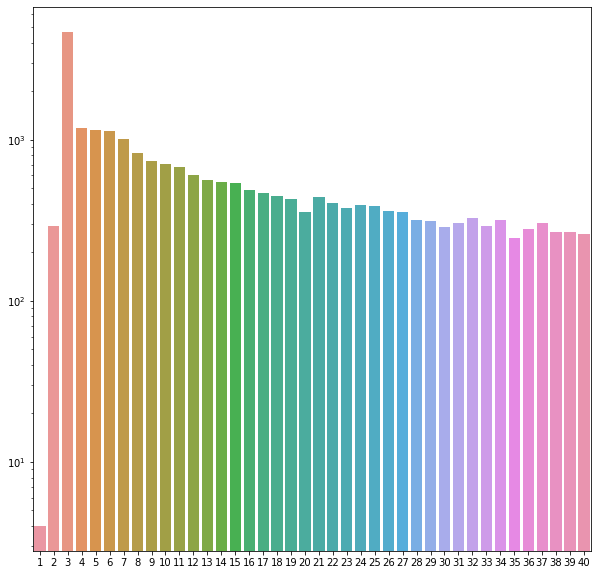

In [85]:
a,b = np.unique(alternate, return_counts=True)
fig, ax = plt.subplots(figsize=(10,10))
ax=sns.barplot(x=a[:40],y=b[:40], ci=None, ax=ax)
ax.set_yscale('log')

In [88]:
len(alternate[alternate>2]) / len(alternate) 

0.9917292598531522

In [89]:
len(alternate[alternate>3]) / len(alternate) 

0.8605226882718654

In [213]:
onlyinnew = newmutations[newmutations.grouped.isin(set(newmutationsset) - set(mutations_20Q2_allset))]
highconf = onlyinnew[(onlyinnew['CGA_WES_AC'].str.split(':').str[0].values.astype(int)>2) & (onlyinnew['PERC_CGA_WES_AC'].values.astype(float)>0.1)]

### We can see that 97% seems to come from good quality additional mutations, we should filter the other ones as is done in guillaume's pipelines

In [214]:
len(highconf)/len(onlyinnew)

0.9770163445579092

### 5-10% are really mutations no one know what to do with

In [237]:
whatarethey = onlyinnew[(onlyinnew['CGA_WES_AC'].str.split(':').str[0].values.astype(int)>20) & (onlyinnew['PERC_CGA_WES_AC'].values.astype(float)<0.2)]

In [238]:
len(whatarethey)/len(onlyinnew)

0.04034095704278842

In [204]:
len(newmutations[newmutations['Variant_Classification']=='Silent'])

290011

## Number of mutation on the same gene

In [186]:
maf = newmutations[newmutations['Variant_Classification']!='Silent']
samplesCol = "Tumor_Sample_Barcode"
mutNameCol="Hugo_Symbol"
col= "CGA_WES_AC"
maf = maf.sort_values(by = mutNameCol)
samples = set(maf[samplesCol])
mut = pd.DataFrame(data = np.zeros((len(set(maf[mutNameCol])), 1)), columns=['fake'], index=set(maf[mutNameCol])).astype(float)
a = {}
du = []
for i,val in enumerate(samples):
    h.showcount(i,len(samples))
    e = maf[maf[samplesCol]==val]
    dups = h.dups(e[mutNameCol])
    a[val] = len(dups)/len(e)
    du.extend(dups)
    #mut = mut.join(maf[maf[samplesCol]==val].drop_duplicates(mutNameCol).set_index(mutNameCol)[col].rename(val))
    #break

In [187]:
a = pd.DataFrame(data=a,index=['dupmut_to_mut'])

In [188]:
a=a.T

In [196]:
a.max(),a.min(),a.mean(),a.var()

(dupmut_to_mut    0.243154
 dtype: float64, dupmut_to_mut    0.0
 dtype: float64, dupmut_to_mut    0.040845
 dtype: float64, dupmut_to_mut    0.001042
 dtype: float64)

### 5% of damaging mutations occur on the same gene.

In [192]:
a.values[0]

array([[0.04017857, 0.00743494, 0.01190476, ..., 0.02314815, 0.02849741,
        0.02985075]])

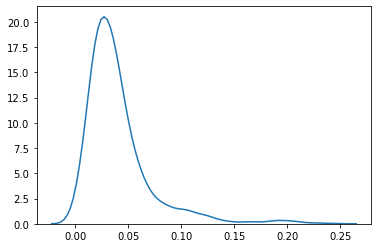

In [193]:
sns.kdeplot(data = a.values[0])

### filtered by silent

In [ ]:
a = pd.DataFrame(data=a,index=['dupmut_to_mut'])

In [209]:
a=a.T

In [210]:
a.max(),a.min(),a.mean(),a.var()

(dupmut_to_mut    0.239054
 dtype: float64, dupmut_to_mut    0.0
 dtype: float64, dupmut_to_mut    0.031965
 dtype: float64, dupmut_to_mut    0.000784
 dtype: float64)

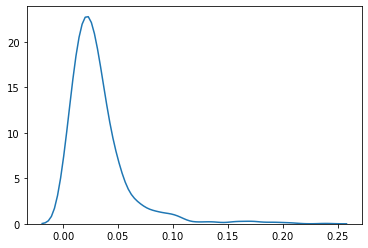

In [211]:
sns.kdeplot(data = a.T.values[0])

In [225]:
from collections import Counter
dudf = pd.DataFrame(data=Counter(du).values(), index=Counter(du).keys(),columns=['counts'])

In [226]:
dudf = dudf.sort_values(by='counts')

In [228]:
dudf.iloc[-50:]

,counts
ANK2,46
UBR4,46
FAT1,46
LAMA1,47
RELN,48
SPTA1,49
FAT2,49
PKHD1,50
LRP1,50
APC,52


In [ ]:
pd.read_csv('ccle_tasks/data/genes.bed')

In [269]:
# normalize the list to gene size

This is linked to gene size and association to cancer:
    - TTN: 250k
    - MUC16: 132 kb
    - LRP1B: 1900kb
    - PCLO: 400kb
    - TP53: 25kb
    
But why would cancer need 2 specific damaging mutations in one very important gene?

- still passenger? (would be a helpful info to estimate what is passenger and what is not)
- one of the mutation was not being effective?
- is there a new phenotype from that?

Why do we get a statistically significative number? 
-> there might be tons of mutations, only the few that are deemed "reportable" by CGA are in the most well known genes. Meaning we are heavily skewed towards these mutations 

## Comparing Sanger vs new data
- sanger processed vs notsanger processed. sanger not in new; in new no in sanger;
- we have maf files for the two pipelines on the same samples

In [249]:
sangmutations_20Q2_all = mutations_20Q2_all[~mutations_20Q2_all['SangerWES_AC'].isna()]

In [250]:
len(sangmutations_20Q2_all) 

624037

In [251]:
sangmutations_20Q2_allset = set(sangmutations_20Q2_all.grouped)

In [259]:
subnewmutationsset = set(newmutations[newmutations.Tumor_Sample_Barcode.isin(sangmutations_20Q2_all.DepMap_ID)].grouped)

### similarity

In [262]:
len(sangmutations_20Q2_allset - subnewmutationsset)

97781

In [263]:
len(subnewmutationsset - sangmutations_20Q2_allset)

79650

In [264]:
alternate = np.array(sangmutations_20Q2_all['SangerWES_AC'].str.split(':').tolist()).astype(int)[:,0]

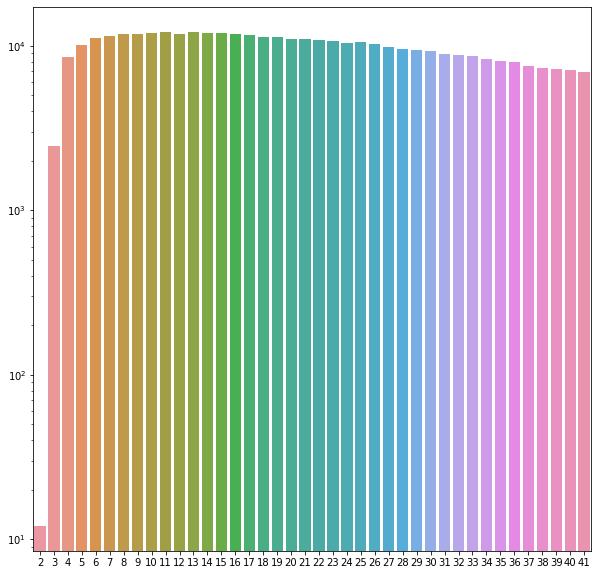

In [265]:
a,b = np.unique(alternate, return_counts=True)
fig, ax = plt.subplots(figsize=(10,10))
ax=sns.barplot(x=a[:40],y=b[:40], ci=None, ax=ax)
ax.set_yscale('log')

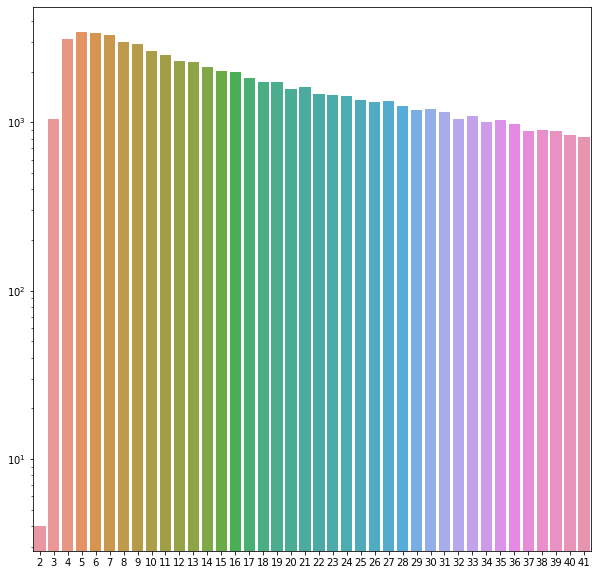

In [266]:
alternate = np.array(sangmutations_20Q2_all[sangmutations_20Q2_all.grouped.isin(sangmutations_20Q2_allset - subnewmutationsset)]['SangerWES_AC'].str.split(':').tolist()).astype(int)[:,0]
a,b = np.unique(alternate, return_counts=True)
fig, ax = plt.subplots(figsize=(10,10))
ax=sns.barplot(x=a[:40],y=b[:40], ci=None, ax=ax)
ax.set_yscale('log')

## working on the new all python pipeline

In [127]:
def filterCoverage(maf, loc=['CGA_WES_AC'], sep=':',cov=4):
    muts=np.zeroes((len(maf),2))
    for val in loc:
        muts+= np.array([[v[0],0] if 'NA' in v else v for v in mutations_20Q2_all[val].fillna('0'+sep+'0').astype(str).str.split(sep).tolist()]).astype(int)
    return maf[muts[:,1]>=cov]

def filterAllelicFraction(maf, loc=['CGA_WES_AC'], sep=':',frac=0.3):
    muts=np.zeroes((len(maf),2))
    for val in loc:
        muts+= np.array([[v[0],0] if 'NA' in v else v for v in mutations_20Q2_all[val].fillna('0'+sep+'0').astype(str).str.split(sep).tolist()]).astype(int)
    muts = muts[:,0]/muts[:,1]
    return maf[muts>=frac]

def mergeAnnotations(newmaf, additionalmaf, additionalonmerge=[]):
    on = ['Chromosome', 'Start_position', 'End_position', 'Reference_Allele', 'Tumor_Seq_Allele1']
    on.extend(additionalonmerge)
    
    newmaf = newmaf.join(additionalmaf, on = on)
    if 
    solve issues with Hugo_Symbol, Entrez_Gene_Id
    
    
    
    return newmad
    
def mergeXY():
    dbSNP_RS.x, dbSNP_RS.y


def addAnnotation(maf, NCBI_Build='37', Strand="+"):
    maf['NCBI_Build'] = NCBI_Build
    maf['Strand'] = Strand
    maf = maf[['current', 'SangerWES_AC', 'SangerRecalibWES_AC', 'RNAseq_AC', 'HC_AC', 'RD_AC', 'WGS_AC']

def mafToMat(maf, col, boolify = False, samplesCol = "DepMap_ID", mutNameCol="Hugo_Symbol"):
    maf = maf.sort_values(by = mutNameCol)
    samples = set(maf[samplesCol])
    mut = pd.DataFrame(data = np.zeros((len(set(maf[mutNameCol])), 1)), columns=['fake'], index=set(maf[mutNameCol])).astype(float)
    for i,val in enumerate(samples):
        h.showcount(i,len(samples))
        mut = mut.join(maf[maf[samplesCol]==val].drop_duplicates(mutNameCol).set_index(mutNameCol)[col].rename(val))
    return mut.nan_to_num(0).astype(bool if boolify else float).drop(columns=['fake'])
    

In [ ]:
filtered_mutations = filterCoverage(mutations)
filtered_mutations = filterAllelicFraction(filtered_mutations)

merged_mutations = addAnnotation(mutations)

mafToMat(filtered_mutations[filtered_mutations.damaging]).to_csv('.csv')
mafToMat(filtered_mutations[filtered_mutations.other]).to_csv('.csv')
mafToMat(filtered_mutations[filtered_mutations.hotspot]).to_csv('.csv')


CCLE2othermutations = 

mutations = mergeAnnotations(filtered_mutations, CCLE2othermutations)

#making 
for muttype in ['']:
    mafToMat(CCLE2othermutations[CCLE2othermutations.damaging & CCLE2othermutations[muttype]]).to_csv(''+muttype+".csv")
    mafToMat(CCLE2othermutations[CCLE2othermutations.other & CCLE2othermutations[muttype]]).to_csv(''+muttype+".csv")
    mafToMat(CCLE2othermutations[CCLE2othermutations.hotspot & CCLE2othermutations[muttype]]).to_csv(''+muttype+".csv")

# Looking at the new unfiltered MAF

In [234]:
unfiltered = res['unfiltered_CGA_MAF_aggregated']
! gsutil cp $unfiltered "temp/mutation_unfiltered_terra_merged.txt"

Copying gs://fc-secure-012d088c-f039-4d36-bde5-ee9b1b76b912/a7fadcdd-57ab-4dee-8bea-5573320261a9/aggregateMAFs_selectFields_workflow/85199362-8bfc-47c4-b093-a3933027128a/call-aggregateMAFs_selectFields/all.mergedMAF.txt...
\ [1 files][ 10.0 GiB/ 10.0 GiB]   48.4 MiB/s                                   
Operation completed over 1 objects/10.0 GiB.                                     


In [311]:
unfiltered = pd.read_csv('temp/mutation_unfiltered_terra_merged.txt', sep='\t', encoding='L6',na_values=["__UNKNOWN__"])

In [363]:
unfiltered = unfiltered.astype(str).replace(['.',"__UNKNOWN__"],None)

In [356]:
toremove = []
for val in unfiltered.columns:
    if len(unfiltered[unfiltered[val]=='__UNKNOWN__'])>3160000:
        toremove.append(val)

In [358]:
unfiltered=unfiltered.drop(columns=toremove)

In [369]:
toremove = []
for val in unfiltered.columns[40:]:
    if len(unfiltered[unfiltered[val]=='nan'])>3160000:
        toremove.append(val)
    elif len(set(unfiltered[val])-set(['nan']))==1:
        toremove.append(val)


KeyboardInterrupt



In [338]:
unfiltered = unfiltered.drop(columns=["UniProt_Site","alt_allele_seen","CCLE_ONCOMAP_overlapping_mutations","failure_reasons","ESP_CA","SVTYPE","id","gnomADg_GT","ESP_GWAS_PUBMED", 'dbSNP_Val_Status', 'qual', 'iHpol', 'QSI_ref', 'BCNoise', 'score', 'Familial_Cancer_Genes_Reference', 'NT']+toremove)

In [399]:
unfiltered['somatic'] = unfiltered['somatic'].replace('nan','False')
unfiltered['HGNC_Status'] = unfiltered['HGNC_Status'].replace('nan','Unapproved')
unfiltered['judgement'] = unfiltered['judgement'].replace('nan','REMOVE')

In [359]:
for val in unfiltered.columns:
    a = unfiltered[val]
    print(val, a[~a.isna()][:10])

Hugo_Symbol 0       CCNL2
1        H6PD
2       FBXO6
3    PRAMEF10
4       PRDM2
5      TMEM51
6       EPHA2
7     SPATA21
8       TMCO4
9       EPHB2
Name: Hugo_Symbol, dtype: object
Entrez_Gene_Id 0     81669
1      9563
2     26270
3    343071
4      7799
5     55092
6      1969
7    374955
8    255104
9      2048
Name: Entrez_Gene_Id, dtype: int64
Chromosome 0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: Chromosome, dtype: object
Start_position 0     1322612
1     9324683
2    11731357
3    12952810
4    14108651
5    15541888
6    16464806
7    16727249
8    20027331
9    23107922
Name: Start_position, dtype: int64
End_position 0     1322612
1     9324683
2    11731357
3    12952810
4    14108651
5    15541888
6    16464806
7    16727249
8    20027331
9    23107922
Name: End_position, dtype: int64
Variant_Classification 0               Silent
1    Missense_Mutation
2               Silent
3               Silent
4    Missense_Mutation
5    Missense_Muta

dbNSFP_aaalt 1     N
2     A
4     F
5     P
6     W
8     K
9     L
10    R
12    Y
14    A
Name: dbNSFP_aaalt, dtype: object
dbNSFP_1000Gp1_ASN_AC 1     0
2     0
4     .
5     .
6     .
8     .
9     .
10    .
12    .
14    .
Name: dbNSFP_1000Gp1_ASN_AC, dtype: object
dbNSFP_SIFT_converted_rankscore 1     0.87932
2           .
4     0.59425
5     0.66056
6     0.87932
8     0.24483
9     0.02654
10    0.87932
12    0.87932
14    0.87932
Name: dbNSFP_SIFT_converted_rankscore, dtype: object
dbNSFP_1000Gp1_ASN_AF 1     0.0
2     0.0
4       .
5       .
6       .
8       .
9       .
10      .
12      .
14      .
Name: dbNSFP_1000Gp1_ASN_AF, dtype: object
TQSI_NT 470    1.0
471    1.0
472    1.0
473    1.0
474    1.0
475    1.0
476    1.0
477    1.0
478    1.0
479    1.0
Name: TQSI_NT, dtype: float64
normal_f 0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: normal_f, dtype: float64
FDP50 470    0.00
471    0.00
472    0.00
473    0.00
474   

ESP_CP 1     1.0
2     0.8
16    0.0
27    1.0
31    0.0
45    0.0
46    1.0
56    1.0
57    1.0
62    0.0
Name: ESP_CP, dtype: object
DP2 470     28.0
471     47.0
472      8.0
473     95.0
474     70.0
475    224.0
476     29.0
477     85.0
478     49.0
479     71.0
Name: DP2, dtype: float64
ESP_Position 0     1322612.0
1     9324683.0
2    11731357.0
3    12952810.0
4    14108651.0
5    15541888.0
6    16464806.0
7    16727249.0
8    20027331.0
9    23107922.0
Name: ESP_Position, dtype: float64
gnomADg_AF_EAS 1                             1.16442e-04
2                             0.00000e+00
3                             0.00000e+00
4     0.00000e+00,0.00000e+00,0.00000e+00
5                             0.00000e+00
6                             0.00000e+00
9                             0.00000e+00
11                            0.00000e+00
12                            0.00000e+00
14                            0.00000e+00
Name: gnomADg_AF_EAS, dtype: object
Transcript_Position 0    1

CSQ 0    T|stop_retained_variant|LOW|CCNL2|ENSG00000221...
1    A|missense_variant|MODERATE|H6PD|ENSG000000492...
2    C|downstream_gene_variant|MODIFIER|MAD2L2|ENSG...
3    A|synonymous_variant|LOW|PRAMEF10|ENSG00000187...
4    T|intron_variant|MODIFIER|PRDM2|ENSG0000011673...
5    C|missense_variant|MODERATE|TMEM51|ENSG0000017...
6    A|upstream_gene_variant|MODIFIER|EPHA2|ENSG000...
7    A|synonymous_variant|LOW|SPATA21|ENSG000001871...
8    T|missense_variant|MODERATE|TMCO4|ENSG00000162...
9    C|missense_variant|MODERATE|EPHB2|ENSG00000133...
Name: CSQ, dtype: object
Other_Variant_Caller 484       Mutect2_2_190617411_190617412_-_A
489        Mutect2_11_32460584_32460584_C_-
492         Mutect2_8_1626460_1626461_-_CAC
506         Mutect2_2_97779488_97779488_C_-
508       Mutect2_9_125391770_125391771_-_A
558        Mutect2_20_49185017_49185017_T_-
603        Mutect2_20_34215234_34215235_-_A
614    Mutect2_3_149238595_149238596_-_TTAA
628       Mutect2_6_32945699_32945701_GAG_-
633 

total_reads 0     96.0
1    127.0
2    244.0
3    185.0
4    977.0
5     43.0
6     49.0
7    339.0
8    173.0
9     71.0
Name: total_reads, dtype: float64
t_ref_max_mapq 0    60.0
1    60.0
2    60.0
3    40.0
4    60.0
5    60.0
6    60.0
7    60.0
8    60.0
9    60.0
Name: t_ref_max_mapq, dtype: float64
dbNSFP_FATHMM_score 1                              0.95
2                                 .
4               4.64;4.52;4.53;4.53
5     1.51;1.51;1.51;1.51;1.51;1.51
6                             -0.04
8                    0.97;0.97;0.97
9          4.63;4.63;4.63;4.63;4.63
10                      -0.07;-0.07
12                        0.35;0.29
14                            -2.81
Name: dbNSFP_FATHMM_score, dtype: object
QSI 470    106.0
471     35.0
472     36.0
473     93.0
474     32.0
475    206.0
476     90.0
477    105.0
478     30.0
479     56.0
Name: QSI, dtype: float64
ESP_GS 1              23
16             64
27            155
31          21,21
45          89,89
46          81

gencode_transcript_status 0    KNOWN
1    KNOWN
2    KNOWN
3    KNOWN
4    KNOWN
5    KNOWN
6    KNOWN
7    KNOWN
8    KNOWN
9    KNOWN
Name: gencode_transcript_status, dtype: object
dbNSFP_Ensembl_transcriptid 1                                       ENST00000377403
2                                       ENST00000449067
4     ENST00000235372;ENST00000311066;ENST0000040080...
5     ENST00000428417;ENST00000376014;ENST0000045132...
6                                       ENST00000358432
8       ENST00000294543;ENST00000375127;ENST00000375122
9     ENST00000374625;ENST00000544305;ENST0000037463...
10      ENST00000361530;ENST00000422547;ENST00000374253
12                      ENST00000373602;ENST00000421922
14                                      ENST00000372587
Name: dbNSFP_Ensembl_transcriptid, dtype: object
CGC_Tumor_Types_Germline 55                     "colorectal, endometrial, ovarian"
595                                     "breast, ovarian"
920                                    

ESP_AA_AC 1     0,4406
2     1,4405
16    1,3851
27    1,4403
31    9,4397
45    1,3851
46    1,4233
56    0,4406
57    0,4406
62    0,3784
Name: ESP_AA_AC, dtype: object
Tumorscape_Deletion_Peaks 0    all_epithelial(116;8.75e-19)|all_lung(118;2.3e...
1    all_epithelial(116;1.28e-19)|all_lung(118;5.22...
2    Lung NSC(185;4.15e-05)|all_lung(284;4.76e-05)|...
3    Renal(390;0.000469)|Lung NSC(185;0.00143)|all_...
4    all_lung(284;2.56e-05)|Lung NSC(185;4.94e-05)|...
5    Renal(390;0.00145)|Breast(348;0.00186)|Colorec...
6    Colorectal(325;3.46e-05)|Breast(348;0.000278)|...
7    Colorectal(325;0.000147)|Renal(390;0.00145)|Lu...
8    Colorectal(325;0.000147)|Renal(390;0.000469)|a...
9    Colorectal(325;3.46e-05)|Lung NSC(340;3.7e-05)...
Name: Tumorscape_Deletion_Peaks, dtype: object
dbNSFP_LR_score 1     0.1001
2     0.1599
4     0.0157
5     0.0699
6     0.4763
8     0.1262
9     0.0068
10    0.4550
12    0.4332
14    0.8533
Name: dbNSFP_LR_score, dtype: object
GO_Molecular_Function 1

TIR 470    26,26
471    16,16
472      7,7
473    38,38
474    18,18
475    70,83
476    25,26
477    49,49
478    18,18
479    15,15
Name: TIR, dtype: object
CGC_Mutation_Type 24                     T
29                     T
55     "D, Mis, N, F, S"
96        "N, F, S, Mis"
237          "T, Mis, O"
297                    T
519             "Mis, O"
527                    T
588                    T
595    "D, Mis, N, F, S"
Name: CGC_Mutation_Type, dtype: object
OREGANNO_ID 22     OREG0013632
39     OREG0014135
146    OREG0016728
250    OREG0020477
266    OREG0020868
293    OREG0021848
296    OREG0021856
329    OREG0022840
380    OREG0024223
390    OREG0024751
Name: OREGANNO_ID, dtype: object
UniProt_AApos 0       0.0
1     711.0
2     107.0
3     454.0
4    1454.0
5     102.0
6     315.0
7     380.0
8     438.0
9      24.0
Name: UniProt_AApos, dtype: float64
dbNSFP_codonpos 1     1
2     2
4     2
5     2
6     1
8     1
9     1
10    2
12    1
14    2
Name: dbNSFP_codonpos, dtype: obj

dbNSFP_MutationAssessor_rankscore 1     0.45422
2           .
4     0.29908
5     0.54323
6     0.89214
8     0.47716
9     0.10645
10    0.88842
12    0.81341
14    0.86953
Name: dbNSFP_MutationAssessor_rankscore, dtype: object
DrugBank 6               Dasatinib(DB01254)|Regorafenib(DB08896)
21                                     Choline(DB00122)
31    Abciximab(DB00054)|Adalimumab(DB00051)|Aleface...
32    Dalteparin(DB06779)|Heparin(DB01109)|Nadropari...
53    Azelaic Acid(DB00548)|Dutasteride(DB01126)|Fin...
65                                 Alendronate(DB00630)
66                          Phosphatidylserine(DB00144)
71                               Valproic Acid(DB00313)
72    Adenosine triphosphate(DB00171)|Bosentan(DB005...
74                      Antithymocyte globulin(DB00098)
Name: DrugBank, dtype: object
dbNSFP_CADD_phred 1     12.17
2     8.126
4     16.51
5     7.709
6      21.2
8     16.55
9     7.766
10     21.0
12     20.7
14    16.07
Name: dbNSFP_CADD_phred, dtype: ob

matched_norm_sample_barcode 0    KMRC2_KIDNEY_Normal-CDS-00rz9N
1    KMRC2_KIDNEY_Normal-CDS-00rz9N
2    KMRC2_KIDNEY_Normal-CDS-00rz9N
3    KMRC2_KIDNEY_Normal-CDS-00rz9N
4    KMRC2_KIDNEY_Normal-CDS-00rz9N
5    KMRC2_KIDNEY_Normal-CDS-00rz9N
6    KMRC2_KIDNEY_Normal-CDS-00rz9N
7    KMRC2_KIDNEY_Normal-CDS-00rz9N
8    KMRC2_KIDNEY_Normal-CDS-00rz9N
9    KMRC2_KIDNEY_Normal-CDS-00rz9N
Name: matched_norm_sample_barcode, dtype: object
gnomADg_AF_ASJ 1                             0.00000e+00
2                             0.00000e+00
3                             0.00000e+00
4     0.00000e+00,0.00000e+00,0.00000e+00
5                             0.00000e+00
6                             0.00000e+00
9                             0.00000e+00
11                            0.00000e+00
12                            0.00000e+00
14                            2.20799e-04
Name: gnomADg_AF_ASJ, dtype: object
dbNSFP_aaref 1     D
2     V
4     S
5     H
6     R
8     E
9     M
10    L
12    H
14    D

In [455]:
toint =  ["Start_position", "End_position"]

In [456]:
for val in toint:
    unfiltered[val]  = unfiltered[val].astype('Int64')

TypeError: object cannot be converted to an IntegerDtype

In [466]:
tofloat = [ "n_ref_count", "t_q20_count", "t_ins_count", "t_lod_fstar", "ESP_AvgAAsampleReadDepth", "TQSI_NT", "normal_f", "FDP50", "t_lod_fstar_forward", "TQSI", "tumor_alt_rpir_median", "ESP_CP", "DP2", "ESP_Position", "RC", "observed_in_normals_count", "Transcript_Exon", "contaminant_lod", "normal_power_wsp", "ESP_TotalAAsamplesCovered", "n_alt_count", "map_Q0_reads", "t_alt_max_mapq", "ESP_CG", "n_q20_count", "QSI_NT", "ESP_TotalSamplesCovered", "contaminant_fraction", "tumor_alt_rpir_mad", "tumor_f", "power_to_detect_negative_strand_artifact", "total_reads", "t_ref_max_mapq", "QSI", "ESP_AvgEAsampleReadDepth", "IHP", "init_n_lod", "ORegAnno_bin", "t_alt_sum", "SUBDP50", "t_lod_fstar_reverse", "read_depth", "t_ref_sum", "n_ref_sum", "gc_content", "t_alt_count", "power_to_detect_positive_strand_artifact", "IC", "normal_power", "UniProt_AApos", "ESP_TotalEAsamplesCovered", "COSMIC_total_alterations_in_gene", "normal_power_nsp", "CCLE_ONCOMAP_total_mutations_in_gene", "init_t_lod", "power", "tumor_alt_fpir_median", "ESP_AvgSampleReadDepth", "tumor_power", "tumor_alt_fpir_mad", "t_del_count", "n_alt_sum", "COSMIC_n_overlapping_mutations", "t_ref_count", "DP50"]

In [467]:
for val in tofloat[5:]:
    try:
        unfiltered[val]  = unfiltered[val].astype(float)
    except:
        print(val)

TQSI_NT
normal_f
FDP50
t_lod_fstar_forward
TQSI
tumor_alt_rpir_median
ESP_CP
DP2
ESP_Position
RC
observed_in_normals_count
Transcript_Exon
contaminant_lod
normal_power_wsp
ESP_TotalAAsamplesCovered
n_alt_count
map_Q0_reads
t_alt_max_mapq
ESP_CG
n_q20_count
QSI_NT
ESP_TotalSamplesCovered
contaminant_fraction
tumor_alt_rpir_mad
tumor_f
power_to_detect_negative_strand_artifact
total_reads
t_ref_max_mapq
QSI
ESP_AvgEAsampleReadDepth
IHP
init_n_lod
ORegAnno_bin
t_alt_sum
SUBDP50
t_lod_fstar_reverse
read_depth
t_ref_sum
n_ref_sum
gc_content
t_alt_count
power_to_detect_positive_strand_artifact
IC
normal_power
UniProt_AApos
ESP_TotalEAsamplesCovered
COSMIC_total_alterations_in_gene
normal_power_nsp
CCLE_ONCOMAP_total_mutations_in_gene
init_t_lod
power
tumor_alt_fpir_median
ESP_AvgSampleReadDepth
tumor_power
tumor_alt_fpir_mad
t_del_count
n_alt_sum
COSMIC_n_overlapping_mutations
t_ref_count
DP50


In [437]:
unfiltered = unfiltered.reset_index()

In [468]:
unfiltered.to_csv('temp/mutation_unfiltered_terra_merged.csv.gz')

In [8]:
unfiltered = pd.read_csv('temp/mutation_unfiltered_terra_merged.csv.gz').drop(columns=['Unnamed: 0','index'])

/home/jeremie/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4,15,17,19,20,22,23,25,26,27,29,31,33,35,37,38,39,40,41,42,43,44,45,50,51,52,54,55,58,60,62,64,65,67,68,69,71,73,77,78,80,81,82,84,86,87,92,95,96,97,98,99,104,106,107,111,112,113,120,122,124,125,127,132,134,138,144,145,146,147,151,152,153,155,161,166,167,170,171,174,180,184,185,189,192,196,197,201,204,206,210,213,216,219,223,225,228,231,238,242,247,249,251,253,254,265,267,268,269,270,271,272,274,277,282) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
unfiltered = unfiltered.rename(columns={'Tumor_Sample_Barcode':'DepMap_ID'})

you need to have installed JKBio in the same folder as ccle_processing


In [25]:
unfiltered.dbSNP_RS.str.contains('|',regex=False).sum() / len(unfiltered)

0.25444826472319204

In [23]:
for val in unfiltered.columns:
    try:
        a = unfiltered[val].str.contains('|',regex=False).sum()
    except:
        continue
    if  a >3:
        print(val)

dbSNP_RS
dbNSFP_aapos_SIFT
dbNSFP_phyloP46way_placental_rankscore
dbNSFP_MutationTaster_score
ESP_AA_GTC
dbNSFP_Ancestral_allele
ClinVar_SYM
dbNSFP_phastCons46way_primate
dbNSFP_phastCons100way_vertebrate
dbNSFP_cds_strand
dbNSFP_MutationAssessor_pred
dbNSFP_1000Gp1_AFR_AC
dbNSFP_1000Gp1_AFR_AF
dbNSFP_phastCons46way_placental_rankscore
ClinVar_TYPE
dbNSFP_LRT_converted_rankscore
dbNSFP_aaalt
dbNSFP_1000Gp1_ASN_AC
dbNSFP_SIFT_converted_rankscore
dbNSFP_1000Gp1_ASN_AF
ESP_MAF
dbNSFP_SiPhy_29way_pi
ESP_DP
dbNSFP_Uniprot_aapos
dbNSFP_Interpro_domain
dbNSFP_aapos_FATHMM
ESP_EA_GTC
dbNSFP_aapos
TCGAscape_Amplification_Peaks
dbNSFP_SLR_test_statistic
dbNSFP_LR_rankscore
dbNSFP_Uniprot_id
dbNSFP_FATHMM_rankscore
dbNSFP_SIFT_pred
TCGAscape_Deletion_Peaks
dbNSFP_LRT_pred
ESP_CP
dbNSFP_phyloP100way_vertebrate_rankscore
strand_bias_counts
dbNSFP_SiPhy_29way_logOdds
dbNSFP_phyloP100way_vertebrate
dbNSFP_ESP6500_AA_AF
UniProt_alt_uniprot_accessions
dbNSFP_SIFT_score
dbNSFP_phyloP46way_primate_ranksc

In [24]:
renaming = removeOlderVersions(names = set(unfiltered.DepMap_ID), refsamples = refwm.get_samples(), arxspan_id = "arxspan_id", version="version")

removed 247 duplicate samples


In [27]:
unfiltered= unfiltered[unfiltered.DepMap_ID.isin(renaming.keys())]
unfiltered.DepMap_ID = unfiltered.DepMap_ID.replace(renaming)

In [272]:
!ls -alh temp/mutation_unfiltered_terra_merged.csv.gz

-rw-r--r-- 1 jeremie jeremie 2.1G Aug 25 22:01 temp/mutation_unfiltered_terra_merged.csv.gz


In [42]:
unfiltered.to_csv('temp/mutation_unfiltered_terra_merged.csv.gz')

In [431]:
unfiltered.to_hdf('temp/mutation_unfiltered_terra_merged.hdf5', 'table')

OverflowError: value too large to convert to int

In [319]:
unfiltered.to_parquet('temp/mutation_unfiltered_terra_merged.parquet', engine='fastparquet')

RuntimeError: Compression 'snappy' not available.  Options: ['GZIP', 'UNCOMPRESSED']

## seperating dbSNP status to the rest

In [465]:
[i for i in unfiltered.columns if 'db' in i]

['dbSNP_RS',
 'dbNSFP_aapos_SIFT',
 'dbNSFP_phyloP46way_placental_rankscore',
 'dbNSFP_MutationTaster_score',
 'dbNSFP_Ancestral_allele',
 'dbNSFP_phastCons46way_primate',
 'dbNSFP_phastCons100way_vertebrate',
 'dbNSFP_cds_strand',
 'dbNSFP_MutationAssessor_pred',
 'dbNSFP_1000Gp1_AFR_AC',
 'dbNSFP_1000Gp1_AFR_AF',
 'dbNSFP_phastCons46way_placental_rankscore',
 'dbNSFP_LRT_converted_rankscore',
 'dbNSFP_aaalt',
 'dbNSFP_1000Gp1_ASN_AC',
 'dbNSFP_SIFT_converted_rankscore',
 'dbNSFP_1000Gp1_ASN_AF',
 'dbNSFP_SiPhy_29way_pi',
 'dbNSFP_Uniprot_aapos',
 'dbNSFP_Interpro_domain',
 'dbNSFP_aapos_FATHMM',
 'dbNSFP_aapos',
 'dbNSFP_SLR_test_statistic',
 'dbNSFP_LR_rankscore',
 'dbNSFP_Uniprot_id',
 'dbNSFP_FATHMM_rankscore',
 'dbNSFP_SIFT_pred',
 'dbNSFP_LRT_pred',
 'dbNSFP_phyloP100way_vertebrate_rankscore',
 'dbNSFP_SiPhy_29way_logOdds',
 'dbNSFP_phyloP100way_vertebrate',
 'dbNSFP_ESP6500_AA_AF',
 'dbNSFP_SIFT_score',
 'dbNSFP_phyloP46way_primate_rankscore',
 'dbNSFP_Polyphen2_HVAR_pred',
 'd

# reprocessing WGS

reprocessing CNV /SV / mutations for WGS

In [44]:
workspace = "broad-firecloud-ccle/DepMap_WGS_CN"
wm = dm.WorkspaceManager(workspace)

In [149]:
sub1 = 'e00f369a-ba2f-4a2f-a8e4-3b6ddc80d3bb'
sub2 = '1ac9bc3f-b22b-417e-9998-5ba07fe776bf'
sub3 = "990e353d-4461-4129-8f23-96bcd8869e75"
sub4 = "b85dec97-262b-454e-b2e5-9452f1048215"

In [101]:
ccle_refsamples = sheets.get(refsheet_url).sheets[0].to_frame()

In [47]:
a = terra.waitForSubmission(workspace,'e00f369a-ba2f-4a2f-a8e4-3b6ddc80d3bb')

CDS-1YwLXW
CDS-7UJrWv
CDS-AHsEp4
CDS-AtxiIO
CDS-IFlU2c
CDS-K9VWSo
CDS-L2WS8G
CDS-LJGHlm
CDS-NDaM5V
CDS-WiJdsP
CDS-aN8PNg
CDS-dIijHP
CDS-fzqrxa
CDS-gILaI6
CDS-hKsmPi
CDS-kU1WWq
CDS-knM0TU
CDS-mYOC4j
CDS-njO2PJ
CDS-uQv8yw
0.9393939393939394 of jobs Succeeded in submission 0.


RuntimeError: 20 failed submission

In [49]:
failed = ["CDS-1YwLXW","CDS-7UJrWv","CDS-AHsEp4","CDS-AtxiIO","CDS-IFlU2c","CDS-K9VWSo","CDS-L2WS8G","CDS-LJGHlm","CDS-NDaM5V","CDS-WiJdsP","CDS-aN8PNg","CDS-dIijHP","CDS-fzqrxa","CDS-gILaI6","CDS-hKsmPi","CDS-kU1WWq","CDS-knM0TU","CDS-mYOC4j","CDS-njO2PJ","CDS-uQv8yw",
]

In [51]:
wm.update_sample_set("failed",failed)

Successfully imported 1 sample sets:
  * failed (20 samples)


cleaning and copying back all hg38_WES samples for CNV pipeline

In [54]:
cnworkspace = "broad-firecloud-ccle/DepMap_WES_CN_hg38"
cnwm = dm.WorkspaceManager(cnworkspace)

In [102]:
ind= ccle_refsamples[(ccle_refsamples.datatype=='wes')].index
ccle_refsamples.loc[ind,'legacy_bam_filepath'] = ccle_refsamples.loc[ind,'internal_bam_filepath']

In [103]:
ind= ccle_refsamples[(ccle_refsamples.datatype=='wes')].index
ccle_refsamples.loc[ind,'legacy_bai_filepath'] = ccle_refsamples.loc[ind,'internal_bai_filepath']

In [104]:
ccle_refsamples = ccle_refsamples.set_index('cds_sample_id')

In [60]:
cnsam = cnwm.get_samples()

In [70]:
cnsam = cnsam.drop('nan')

In [105]:
ccle_refsamples.loc[cnsam.index,'internal_bai_filepath'] = cnsam.hg38_analysis_ready_bam_index

In [106]:
ccle_refsamples.loc[cnsam.index,'internal_bam_filepath'] = cnsam.hg38_analysis_ready_bam

In [107]:
ccle_refsamples['md5_hash'] = None

In [108]:
ccle_refsamples['legacy_size'] = None
ccle_refsamples['legacy_crc32c_hash'] = None

In [109]:
ind= ccle_refsamples[(ccle_refsamples.datatype=='wes')].index
ccle_refsamples.loc[ind,'legacy_size'] = ccle_refsamples.loc[ind,'size']
ccle_refsamples.loc[ind,'legacy_crc32c_hash'] = ccle_refsamples.loc[ind,'crc32c_hash']

In [112]:
ccle_refsamples.loc[cnsam.index,'md5_hash'] = gcp.catFiles(cnsam.hg38_analysis_ready_bam_md5, cut=50)

0.0
0.02605523710265763
0.05211047420531526
0.0781657113079729
0.10422094841063052
0.13027618551328815
0.1563314226159458
0.18238665971860343
0.20844189682126105
0.2344971339239187
0.2605523710265763
0.28660760812923397
0.3126628452318916
0.3387180823345492
0.36477331943720687
0.3908285565398645
0.4168837936425221
0.44293903074517976
0.4689942678478374
0.495049504950495
0.5211047420531526
0.5471599791558103
0.5732152162584679
0.5992704533611255
0.6253256904637832
0.6513809275664408
0.6774361646690984
0.7034914017717561
0.7295466388744137
0.7556018759770713
0.781657113079729
0.8077123501823866
0.8337675872850442
0.8598228243877019
0.8858780614903595
0.9119332985930171
0.9379885356956748
0.9640437727983324
0.99009900990099


ValueError: Must have equal len keys and value when setting with an iterable

In [129]:
ccle_refsamples.loc[cnsam.index,'size']

sample_id
CDS-00rz9N     8949130033
CDS-01bI6z    11799933048
CDS-02waxZ     5362070468
CDS-04TUV3     7854895154
CDS-051M8l     9729007060
                 ...     
CDS-zyxdAN    10207643531
CDS-zzbiLf     5860708918
CDS-zZfEtt     9903418913
CDS-ZzuUDl    17061492797
CDS-ZZvhFD     5266440232
Name: size, Length: 1919, dtype: int64

In [125]:
ccle_refsamples.loc[cnsam.index,'size'] = [gcp.extractSize(i)[1] for i in gcp.lsFiles(cnsam.hg38_analysis_ready_bam.tolist(), add='-l')]

listing files in gs


In [130]:
ccle_refsamples = ccle_refsamples.drop(index=ccle_refsamples[ccle_refsamples.datatype=='hg38_wes'].index)

,arxspan_id,version,sm_id,datatype,size,ccle_name,stripped_cell_line_name,patient_id,cellosaurus_id,bam_public_sra_path,...,18q3,18q4,19q1,19q2,19q3,19q4,20q1,20q2,legacy_size,legacy_crc32c_hash
cds_sample_id,,,,,,,,,,,,,,,,,,,,,
CDS-xzEyFR,ACH-000202,1,NaN,hybrid_capture,877045815,NaN,COLO320,PT-emNEMU8h,CVCL_1989,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
CDS-iaYJ7f,ACH-000114,1,NaN,hybrid_capture,912573952,NaN,SU8686,PT-PztFvGAF,CVCL_3881,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
CDS-5gFrc6,ACH-000070,1,NaN,hybrid_capture,933555291,NaN,697,PT-G2saKAKd,CVCL_0079,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
CDS-j80PHR,ACH-000594,1,NaN,hybrid_capture,983813719,NaN,DMS153,PT-tYlQs0Z3,CVCL_1175,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
CDS-8kskIl,ACH-000969,1,NaN,hybrid_capture,1020130394,NaN,KM12,PT-7uMI3v4f,CVCL_1331,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CDS-IFlU2c,ACH-000360,1,NaN,wgs,277744940538,NaN,NCIH508,PT-WLPrFoJ3,CVCL_1564,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
CDS-o6r3vt,ACH-000749,1,NaN,wgs,163965124526,NaN,DMS273,PT-cTrqO8HE,CVCL_1176,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
CDS-ODzhDx,ACH-000243,1,NaN,wgs,181428011897,NaN,DANG,PT-CPFTAKCt,CVCL_0243,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None


removing cached data for WGS and copying back hg38 to bucket

In [134]:
ind = ccle_refsamples[ccle_refsamples.datatype=="wgs"].index

In [135]:
ccle_refsamples.loc[ind,'legacy_bam_filepath'] = ccle_refsamples.loc[ind,'internal_bam_filepath']
ccle_refsamples.loc[ind,'legacy_bai_filepath'] = ccle_refsamples.loc[ind,'internal_bai_filepath']
ccle_refsamples.loc[ind,'legacy_size'] = ccle_refsamples.loc[ind,'size']
ccle_refsamples.loc[ind,'legacy_crc32c_hash'] = ccle_refsamples.loc[ind,'crc32c_hash']

In [136]:
wgsworkspace = "broad-firecloud-ccle/DepMap_WGS_CN"
wgswm = dm.WorkspaceManager(wgsworkspace)

In [307]:
sam = wgswm.get_samples()

In [308]:
ccle_refsamples.loc[sam.index,'internal_bai_filepath'] = sam.analysis_ready_bam_index
ccle_refsamples.loc[sam.index,'internal_bam_filepath'] = sam.analysis_ready_bam

In [146]:
ccle_refsamples.loc[sam.index,'md5_hash'] = gcp.catFiles(sam.analysis_ready_bam_md5, cut=32)

0.0
0.15151515151515152
0.30303030303030304
0.4545454545454546
0.6060606060606061
0.7575757575757576
0.9090909090909092


In [148]:
ccle_refsamples.loc[sam.index,'size'] = [gcp.extractSize(i)[1] for i in gcp.lsFiles(sam.analysis_ready_bam.tolist(), add='-l')]

listing files in gs


In [292]:
sam.analysis_ready_bam[1]

'gs://fc-secure-bd7b8bc9-f665-4269-997e-5a402088a369/e00f369a-ba2f-4a2f-a8e4-3b6ddc80d3bb/PreProcessingForVariantDiscovery_GATK4/9f0a970a-20fc-48a7-bcdb-8ece1748d67d/call-GatherBamFiles/CDS-0sdrSB.wgs_ccle.bam'

In [ ]:
hou

In [297]:
terra.changeGSlocation(wgsworkspace, "gs://cclebams/wgs_hg38/", entity='sample', onlycol=['analysis_ready_bam','analysis_ready_bam_index',"analysis_ready_bam_md5"],keeppath=False, dry_run=False)

using the data from broad-firecloud-ccle/DepMap_WGS_CN sample list
this should only contains gs:// paths otherwise precise columns using "onlycol"
Successfully updated attributes '['analysis_ready_bam', 'analysis_ready_bam_index', 'analysis_ready_bam_md5']' for 330 samples.
Hound executing batch upload of 2640 records


(                                        analysis_ready_bam  \
 CDS-00Nrci  gs://cclebams/wgs_hg38/CDS-00Nrci.wgs_ccle.bam   
 CDS-0sdrSB  gs://cclebams/wgs_hg38/CDS-0sdrSB.wgs_ccle.bam   
 CDS-0Z9yIY  gs://cclebams/wgs_hg38/CDS-0Z9yIY.wgs_ccle.bam   
 CDS-17moNf  gs://cclebams/wgs_hg38/CDS-17moNf.wgs_ccle.bam   
 CDS-1pLoxn  gs://cclebams/wgs_hg38/CDS-1pLoxn.wgs_ccle.bam   
 ...                                                    ...   
 CDS-Z5r6HS  gs://cclebams/wgs_hg38/CDS-Z5r6HS.wgs_ccle.bam   
 CDS-zClyZ7  gs://cclebams/wgs_hg38/CDS-zClyZ7.wgs_ccle.bam   
 CDS-ZEQ9PP  gs://cclebams/wgs_hg38/CDS-ZEQ9PP.wgs_ccle.bam   
 CDS-ZJh6UN  gs://cclebams/wgs_hg38/CDS-ZJh6UN.wgs_ccle.bam   
 CDS-ZRSoyP  gs://cclebams/wgs_hg38/CDS-ZRSoyP.wgs_ccle.bam   
 
                                   analysis_ready_bam_index  \
 CDS-00Nrci  gs://cclebams/wgs_hg38/CDS-00Nrci.wgs_ccle.bai   
 CDS-0sdrSB  gs://cclebams/wgs_hg38/CDS-0sdrSB.wgs_ccle.bai   
 CDS-0Z9yIY  gs://cclebams/wgs_hg38/CDS-0Z9yIY.wgs_cc

In [299]:
terra.cleanWorkspace(wgsworkspace, only=[sub1, sub2, sub3, sub4])

we are going to remove 4 files/folders:
['gs://fc-secure-bd7b8bc9-f665-4269-997e-5a402088a369/1ac9bc3f-b22b-417e-9998-5ba07fe776bf/', 'gs://fc-secure-bd7b8bc9-f665-4269-997e-5a402088a369/990e353d-4461-4129-8f23-96bcd8869e75/', 'gs://fc-secure-bd7b8bc9-f665-4269-997e-5a402088a369/b85dec97-262b-454e-b2e5-9452f1048215/', 'gs://fc-secure-bd7b8bc9-f665-4269-997e-5a402088a369/e00f369a-ba2f-4a2f-a8e4-3b6ddc80d3bb/']
are you sure?
y


In [300]:
a = gcp.get_all_sizes('gs://fc-secure-bd7b8bc9-f665-4269-997e-5a402088a369/', suffix='bam')

In [306]:
! gsutil -m rm gs://fc-secure-bd7b8bc9-f665-4269-997e-5a402088a369/*/PreProcessingForVariantDiscovery_GATK4/**.bam

Removing gs://fc-secure-bd7b8bc9-f665-4269-997e-5a402088a369/6878c36f-dc84-4a4d-8c07-af8f8796a922/PreProcessingForVariantDiscovery_GATK4/52dd9d05-833c-4131-9293-e57e92cc4320/call-MergeBamAlignment/shard-0/cacheCopy/C1WYN.1.unmapped.aligned.unsorted.bam...
Removing gs://fc-secure-bd7b8bc9-f665-4269-997e-5a402088a369/6878c36f-dc84-4a4d-8c07-af8f8796a922/PreProcessingForVariantDiscovery_GATK4/52dd9d05-833c-4131-9293-e57e92cc4320/call-MergeBamAlignment/shard-1/cacheCopy/D2066.1.unmapped.aligned.unsorted.bam...
Removing gs://fc-secure-bd7b8bc9-f665-4269-997e-5a402088a369/6878c36f-dc84-4a4d-8c07-af8f8796a922/PreProcessingForVariantDiscovery_GATK4/52dd9d05-833c-4131-9293-e57e92cc4320/call-MergeBamAlignment/shard-2/cacheCopy/D2066.2.unmapped.aligned.unsorted.bam...
Removing gs://fc-secure-bd7b8bc9-f665-4269-997e-5a402088a369/6878c36f-dc84-4a4d-8c07-af8f8796a922/PreProcessingForVariantDiscovery_GATK4/52dd9d05-833c-4131-9293-e57e92cc4320/call-SamToFastqAndBwaMem/shard-0/cacheCopy/C1WYN.1.unmappe

Removing gs://fc-secure-bd7b8bc9-f665-4269-997e-5a402088a369/8bb2df28-f257-4688-8024-6961dc88a572/PreProcessingForVariantDiscovery_GATK4/237497dd-3d8d-4c77-89a3-9e22db8f4981/call-SortAndFixTags/cacheCopy/ccle_ACH-000045.wgs_ccle.aligned.duplicate_marked.sorted.bam...
Removing gs://fc-secure-bd7b8bc9-f665-4269-997e-5a402088a369/e89e8001-fd34-4d7b-8884-8a2377e3f2b9/PreProcessingForVariantDiscovery_GATK4/8576a2be-6301-4c9d-9b70-efdd5443a03d/call-MergeBamAlignment/shard-0/C1WYN.1.unmapped.aligned.unsorted.bam...
Removing gs://fc-secure-bd7b8bc9-f665-4269-997e-5a402088a369/e89e8001-fd34-4d7b-8884-8a2377e3f2b9/PreProcessingForVariantDiscovery_GATK4/8576a2be-6301-4c9d-9b70-efdd5443a03d/call-MergeBamAlignment/shard-1/D2066.1.unmapped.aligned.unsorted.bam...
Removing gs://fc-secure-bd7b8bc9-f665-4269-997e-5a402088a369/e89e8001-fd34-4d7b-8884-8a2377e3f2b9/PreProcessingForVariantDiscovery_GATK4/8576a2be-6301-4c9d-9b70-efdd5443a03d/call-MergeBamAlignment/shard-2/attempt-2/D2066.2.unmapped.aligned.

In [309]:
ccle_refsamples.to_csv('temp/newsamples.csv')